In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('yellow_tripdata_2024-01.parquet')

gdf = gpd.read_file('geo_export_8f5b4af4-3621-43a0-adae-1e43de9e9e98.shp')

In [3]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


C:\Users\User\AppData\Local\Temp\ipykernel_11828\2512625014.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(boroughs.geometry.centroid.x, boroughs.geometry.centroid.y, boroughs.index):


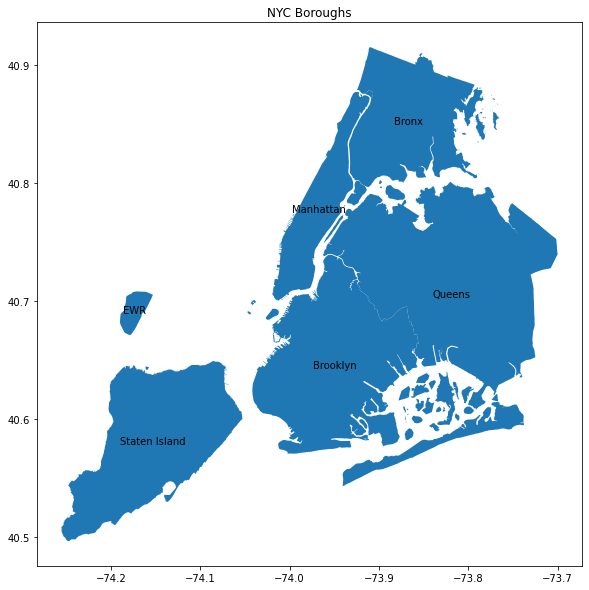

In [4]:
boroughs = gdf.dissolve(by='borough')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
boroughs.plot(ax=ax, legend=False)

for x, y, label in zip(boroughs.geometry.centroid.x, boroughs.geometry.centroid.y, boroughs.index):
    ax.text(x, y, label, fontsize=10, ha='center', va='center')

plt.title('NYC Boroughs')
plt.show()

# Analysis 1 - Negative Fare Rate

- 1.3% of recorded NYC taxi trips have resulted in a negative fare amount (37446/2964624). 
- We aim to identify the locations where negative fare amounts occur most frequently, where the rate of negative fares is highest, and where the average negative fare amount is the greatest. 

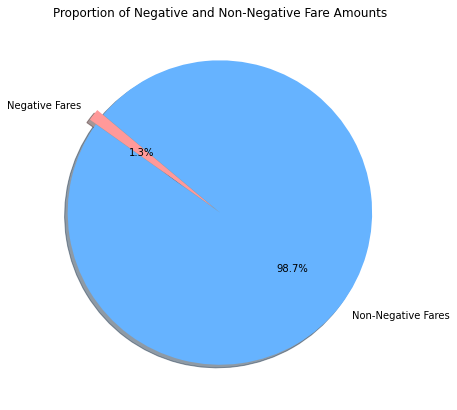

In [5]:
negative_fares_count = df[df['fare_amount'] < 0].shape[0]
non_negative_fares_count = df[df['fare_amount'] >= 0].shape[0]

labels = ['Negative Fares', 'Non-Negative Fares']
sizes = [negative_fares_count, non_negative_fares_count]
colors = ['#ff9999','#66b3ff']
explode = (0.05, 0) 

fig, ax = plt.subplots(figsize=(14, 7))
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=140)
ax.set_title('Proportion of Negative and Non-Negative Fare Amounts')

plt.show()

In [6]:
negative_fares_count = df[df['fare_amount'] < 0].copy()
print(f'Negative Fares Count : {negative_fares_count.shape[0]}')

Negative Fares Count : 37448


### Most Frequent

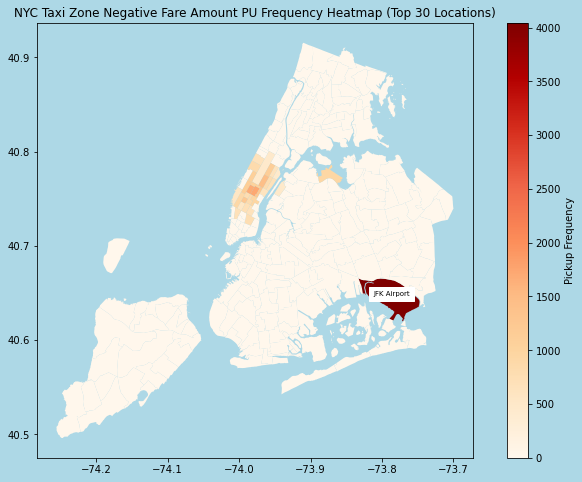

In [7]:
pulocation_counts = negative_fares_count['PULocationID'].value_counts().sort_index()

pulocation_counts_sorted = pulocation_counts.sort_values(ascending=False)

gdf['location_i'] = gdf['location_i'].astype(int)

top30_pulocation_counts_sorted = pulocation_counts_sorted.head(30).reset_index()
top30_pulocation_counts_sorted.columns = ['location_i', 'count']

top1_location = top30_pulocation_counts_sorted.iloc[0]

merged_gdf = gdf.merge(top30_pulocation_counts_sorted, on='location_i', how='left')

merged_gdf['count'].fillna(0, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fig.patch.set_facecolor('#ADD8E6')
ax.set_facecolor('#ADD8E6') 

merged_gdf.plot(column='count', ax=ax, legend=True, cmap='OrRd', legend_kwds={'label': "Pickup Frequency"})

top1_row = merged_gdf[merged_gdf['location_i'] == top1_location['location_i']].iloc[0]
plt.annotate(text=top1_row['zone'], xy=(top1_row['geometry'].centroid.x, top1_row['geometry'].centroid.y),
             ha='center', fontsize=7, color='black', backgroundcolor='white')

plt.title('NYC Taxi Zone Negative Fare Amount PU Frequency Heatmap (Top 30 Locations)')
plt.show()

- JFK Airport stands out as a significant outlier among the most frequent pickup locations resulting in negative fare amounts.
- The Manhattan borough encompasses a significant majority of the zones with negative fare amounts.

### Highest Negative Fare Rate

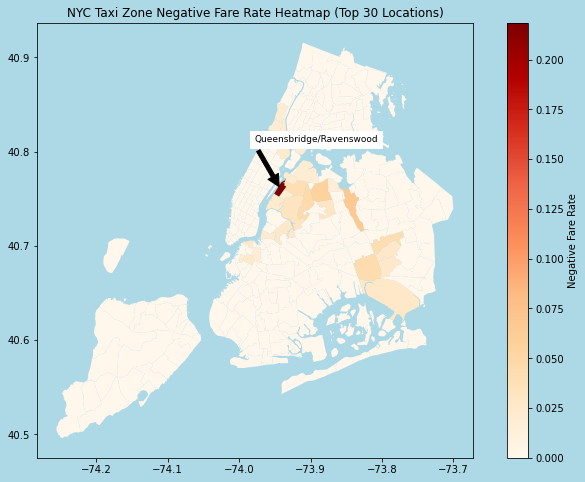

In [8]:
total_fares_per_location = df.groupby('PULocationID').size()

filtered_total_fares = total_fares_per_location[total_fares_per_location >= 500]

negative_fares_per_location = df[df['fare_amount'] < 0].groupby('PULocationID').size()

negative_fare_rate = (negative_fares_per_location / filtered_total_fares).fillna(0)

negative_fare_rate_df = pd.DataFrame({
    'location_i': negative_fare_rate.index,
    'negative_fare_rate': negative_fare_rate.values
})

top30_negative_fare_rate_df = negative_fare_rate_df.nlargest(30, 'negative_fare_rate')

merged_gdf = gdf.merge(top30_negative_fare_rate_df, on='location_i', how='left')

merged_gdf['negative_fare_rate'].fillna(0, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fig.patch.set_facecolor('#ADD8E6')
ax.set_facecolor('#ADD8E6')

merged_gdf.plot(column='negative_fare_rate', ax=ax, legend=True, cmap='OrRd', legend_kwds={'label': "Negative Fare Rate"})

if not top30_negative_fare_rate_df.empty:
    top1_location = merged_gdf.loc[merged_gdf['negative_fare_rate'].idxmax()]
    top1_location_coords = top1_location['geometry'].centroid.coords[0]
    ax.annotate(
        text=top1_location['zone'],
        xy=top1_location_coords,
        xytext=(top1_location_coords[0] + 0.05, top1_location_coords[1] + 0.05),
        ha='center', fontsize=9, color='black', backgroundcolor='white',
        arrowprops=dict(facecolor='black', shrink=0.05)
    )

plt.title('NYC Taxi Zone Negative Fare Rate Heatmap (Top 30 Locations)')
plt.show()

- Zones with fewer than 500 pickups were excluded to prevent inflated trip rate due to small sample sizes.
- The Queensbridge/Ravenswood zone has the highest negative fare rate at 2.18%.
- Unlike pickup frequency, most of the highest negative fare rates are found in the Queens borough. 
- The JFK Airport has the 11th highest rate.

### Highest Average Negative Fare Amounts

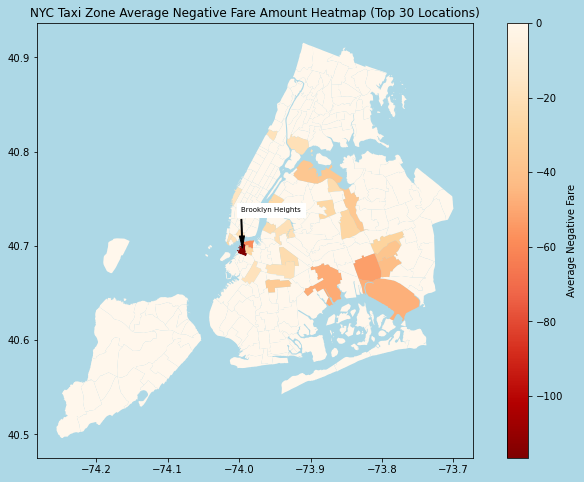

In [9]:
total_fares_per_location = df.groupby('PULocationID').size()

filtered_total_fares = total_fares_per_location[total_fares_per_location >= 500]

negative_fares = df[df['fare_amount'] < 0]
average_negative_fare_per_location = negative_fares.groupby('PULocationID')['fare_amount'].mean()

average_negative_fare_per_location_filtered = average_negative_fare_per_location[average_negative_fare_per_location.index.isin(filtered_total_fares.index)]

average_negative_fare_df = pd.DataFrame({
    'location_i': average_negative_fare_per_location_filtered.index,
    'average_negative_fare': average_negative_fare_per_location_filtered.values
})

top30_average_negative_fare_df = average_negative_fare_df.nsmallest(30, 'average_negative_fare')

merged_gdf = gdf.merge(top30_average_negative_fare_df, on='location_i', how='left')

merged_gdf['average_negative_fare'].fillna(0, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fig.patch.set_facecolor('#ADD8E6') 
ax.set_facecolor('#ADD8E6')  

merged_gdf.plot(column='average_negative_fare', ax=ax, legend=True, cmap='OrRd_r', 
                legend_kwds={'label': "Average Negative Fare"})

if not top30_average_negative_fare_df.empty:
    top1_location = merged_gdf.loc[merged_gdf['average_negative_fare'].idxmin()]  # idxmin for the most negative
    top1_location_coords = top1_location['geometry'].centroid.coords[0]
    ax.annotate(
        text=top1_location['zone'],
        xy=top1_location_coords,
        xytext=(top1_location_coords[0] + 0.04, top1_location_coords[1] + 0.04),  # Increase offset for longer arrow
        ha='center', fontsize=7, color='black', backgroundcolor='white',
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5)
    )

plt.title('NYC Taxi Zone Average Negative Fare Amount Heatmap (Top 30 Locations)')
plt.show()

- Zones with fewer than 500 trips were excluded.
- Brooklyn Heights has the highest average negative fare amount at -$116.
- The distribution of zones with negative fares is more evenly spread across the Manhattan, Brooklyn, and Queens boroughs. 
- JFK Airport ranks sixth in average negative fare amount. 

# Analysis 2 - Temporal Trends in NYC Taxi PickUp Frequencies

- The busiest period for NYC taxis is from 7 AM to 10 PM. We aim to identify the zones with the highest pickup frequencies for each hour within this timeframe.

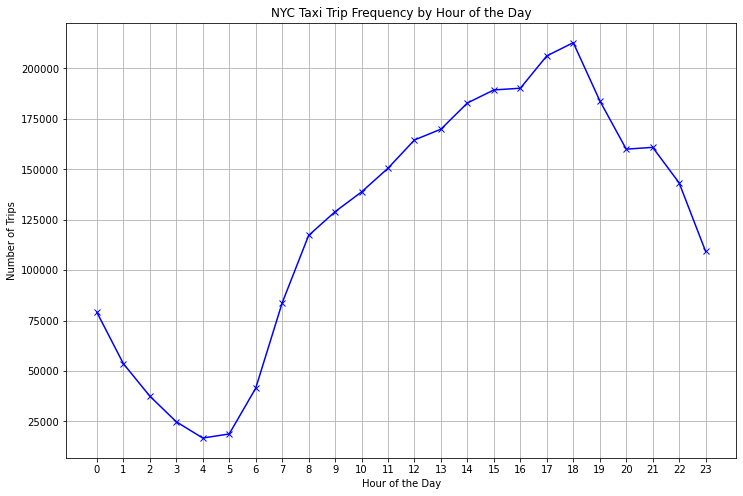

In [10]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

df['hour'] = df['tpep_pickup_datetime'].dt.hour

hourly_trip_counts = df.groupby('hour').size()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(hourly_trip_counts.index, hourly_trip_counts.values, marker='x', linestyle='-', color='b')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Number of Trips')
ax.set_title('NYC Taxi Trip Frequency by Hour of the Day')
ax.grid(True)

plt.xticks(range(24)) 
plt.show()

- Temporal trends show a predictable pattern with fewer trips during inactive hours (1 AM - 6 AM) and more trips during active hours (7 AM - 7 PM).

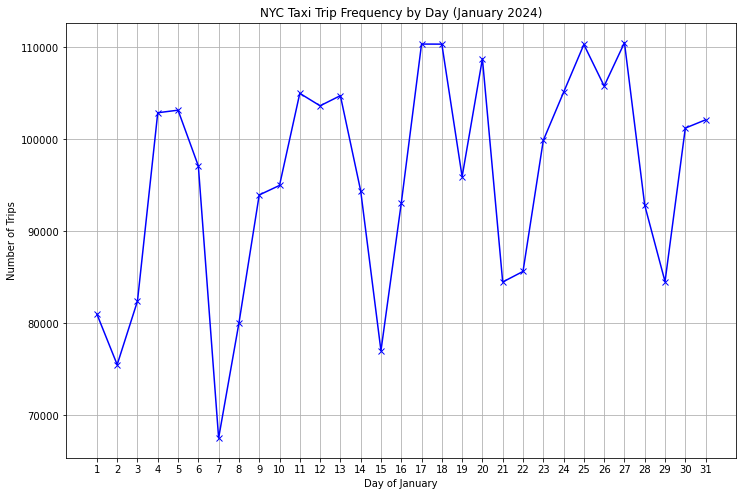

In [11]:
df['day'] = df['tpep_pickup_datetime'].dt.day

daily_trip_counts = df.groupby('day').size()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(daily_trip_counts.index, daily_trip_counts.values, marker='x', linestyle='-', color='b')
ax.set_xlabel('Day of January')
ax.set_ylabel('Number of Trips')
ax.set_title('NYC Taxi Trip Frequency by Day (January 2024)')
ax.grid(True)

plt.xticks(range(1, 32))
plt.show()

- Weekends and Mondays see a lower number of trips, while weekdays have higher numbers. There is a slight upward trend in trips throughout January 
- January 15th, which is Washington's Birthday (a public holiday), has the third-lowest number of trips for the month. 

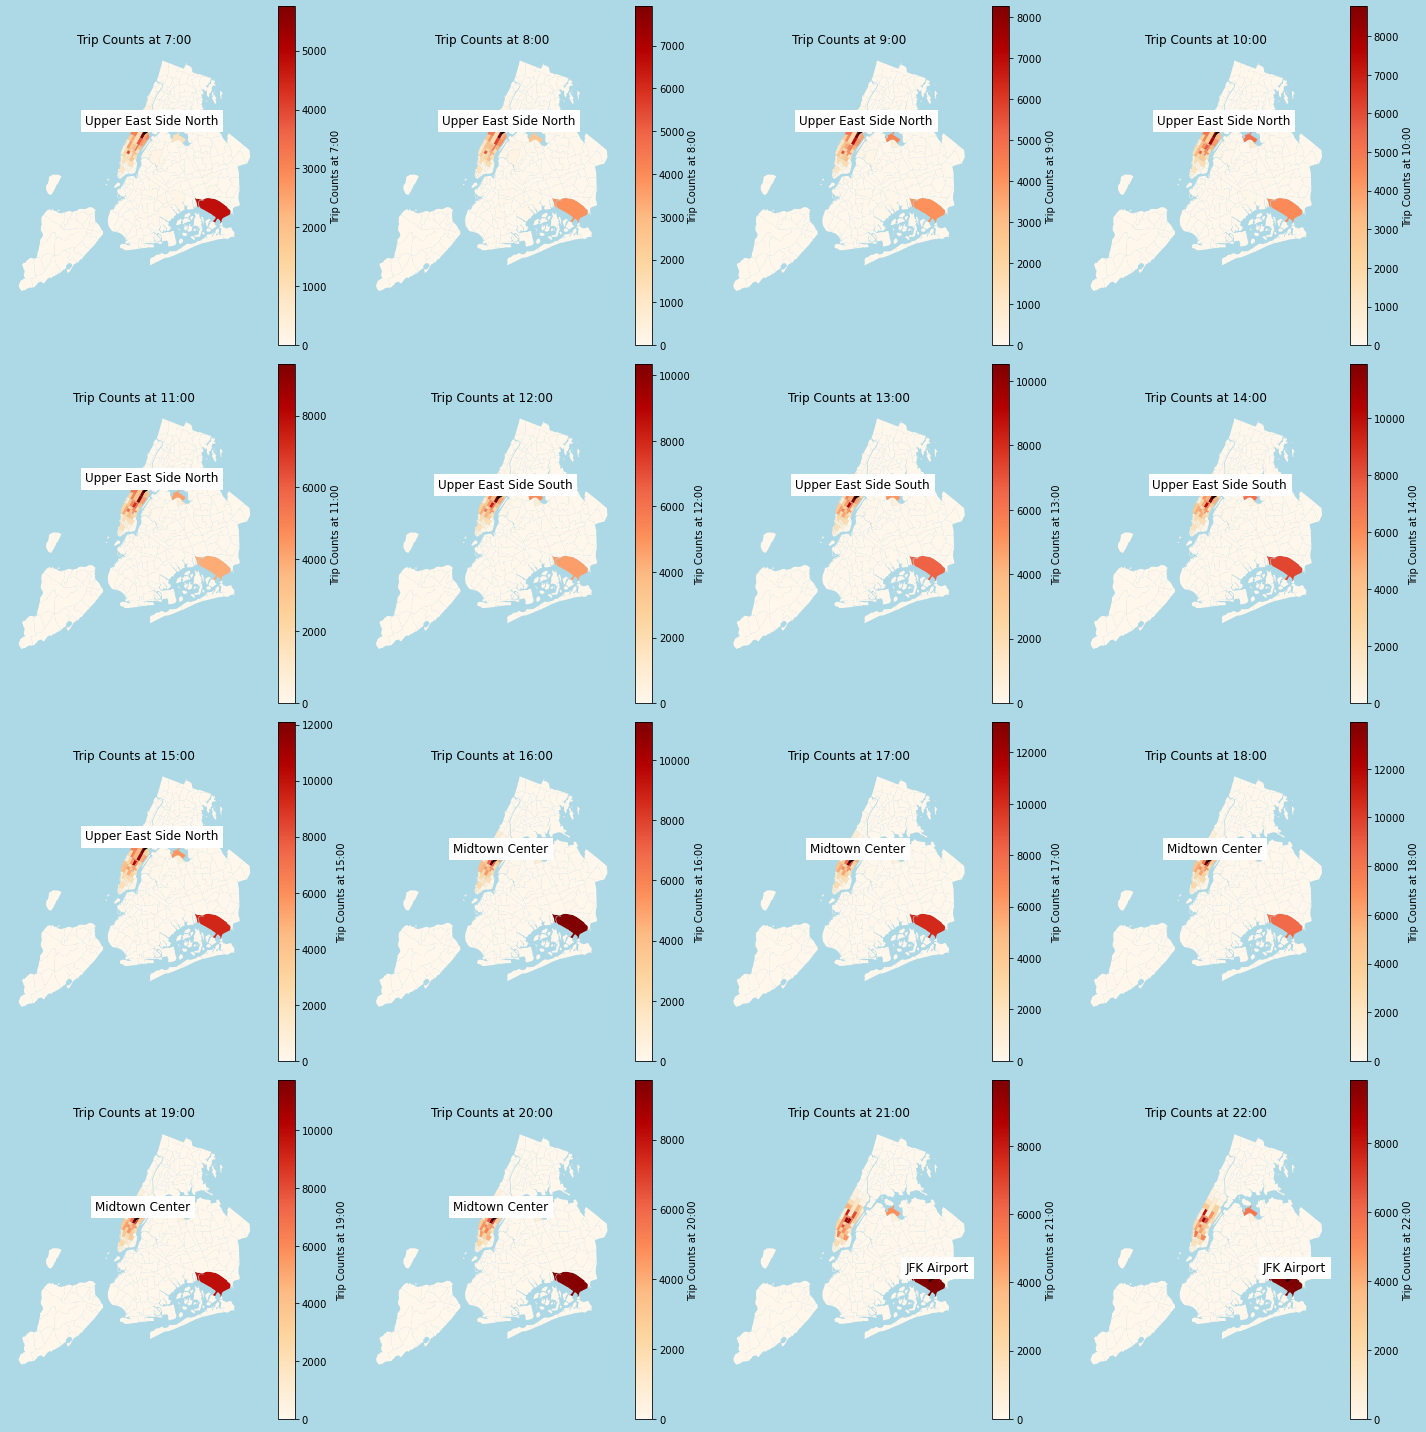

In [12]:
filtered_df = df[(df['hour'] >= 7) & (df['hour'] <= 22)]

hourly_trip_counts = filtered_df.groupby(['PULocationID', 'hour']).size().reset_index(name='trip_count')

pivot_table = hourly_trip_counts.pivot(index='PULocationID', columns='hour', values='trip_count').fillna(0)

fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharex=True, sharey=True)
hours = list(range(7, 23))  # Hours from 7 AM to 10 PM
axes = axes.flatten()

fig.patch.set_facecolor('#ADD8E6')
ax.set_facecolor('#ADD8E6')

for i, hour in enumerate(hours):
    hour_trip_counts = pivot_table[hour].reset_index()
    merged_gdf = gdf.merge(hour_trip_counts, left_on='location_i', right_on='PULocationID', how='left')
    
    merged_gdf[hour] = merged_gdf[hour].fillna(0)
    
    merged_gdf.plot(column=hour, ax=axes[i], legend=True, cmap='OrRd', legend_kwds={'label': f"Trip Counts at {hour}:00"})
    axes[i].set_title(f'Trip Counts at {hour}:00')
    axes[i].set_axis_off()
    
    if not hour_trip_counts.empty:
        top_location = merged_gdf.loc[merged_gdf[hour].idxmax()]
        top_location_coords = top_location['geometry'].centroid.coords[0]
        axes[i].annotate(
            text=top_location['zone'],
            xy=top_location_coords,
            xytext=(top_location_coords[0] + 0.02, top_location_coords[1] + 0.02),  # Adjust offset for arrow
            ha='center', fontsize=12, color='black', backgroundcolor='white',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5)
        )

plt.tight_layout()
plt.show()

- Upper East Side North (7 AM - 3 PM): This area is primarily residential, leading to high taxi demand in the morning as residents commute to work.
- Midtown Center (4 PM - 8 PM): As a major business district, this area sees increased taxi pickups in the evening when people finish work and head home.
- JFK Airport (9 PM - 10 PM): The high number of evening flights arriving at JFK Airport results in a peak in taxi pickups during these hours.

# Analysis 3 - Most Expensive Trips

- We aim to investigate the top 10 most expensive zones during the two peak expense hours (5 AM and 4 PM) and the two least expensive hours (7 AM and 9 PM). 

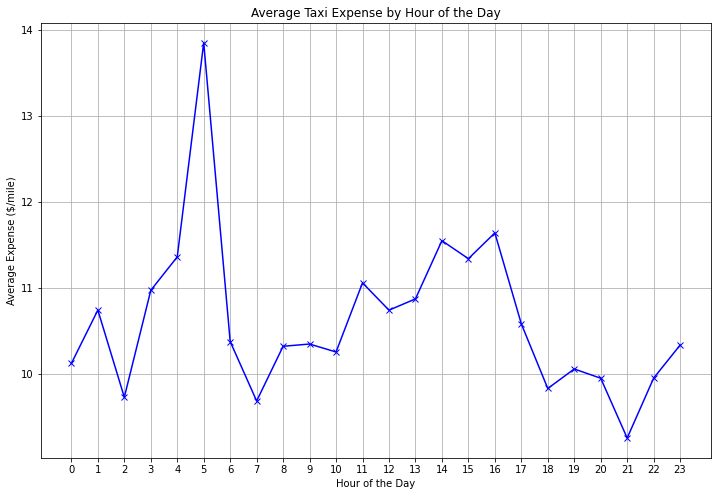

In [13]:
# Step 2: Calculate the expense for each trip
df['expense'] = df['fare_amount'] / df['trip_distance']

# Filter out trips with 0 trip_distance to avoid division by zero errors
df = df[df['trip_distance'] > 0]

# Aggregate the average expense by hour
hourly_expense = df.groupby('hour')['expense'].mean().reset_index()

# Step 4: Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(hourly_expense['hour'], hourly_expense['expense'], marker='x', linestyle='-', color='b')
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Average Expense ($/mile)')
ax.set_title('Average Taxi Expense by Hour of the Day')
ax.grid(True)

plt.xticks(range(24))  # Ensure all hours are shown on the x-axis
plt.show()

- The peak at 5 AM can be attributed to the shift change for taxi drivers. Many drivers end their shifts around this time, leading to a temporary reduction in the number of available taxis. The scarcity of taxis can drive up the cost per mile.

- By 9 PM, more taxis are typically available as drivers who started their shifts in the afternoon are still on the road, and some night shift drivers have started. This increased supply can lead to lower fares.

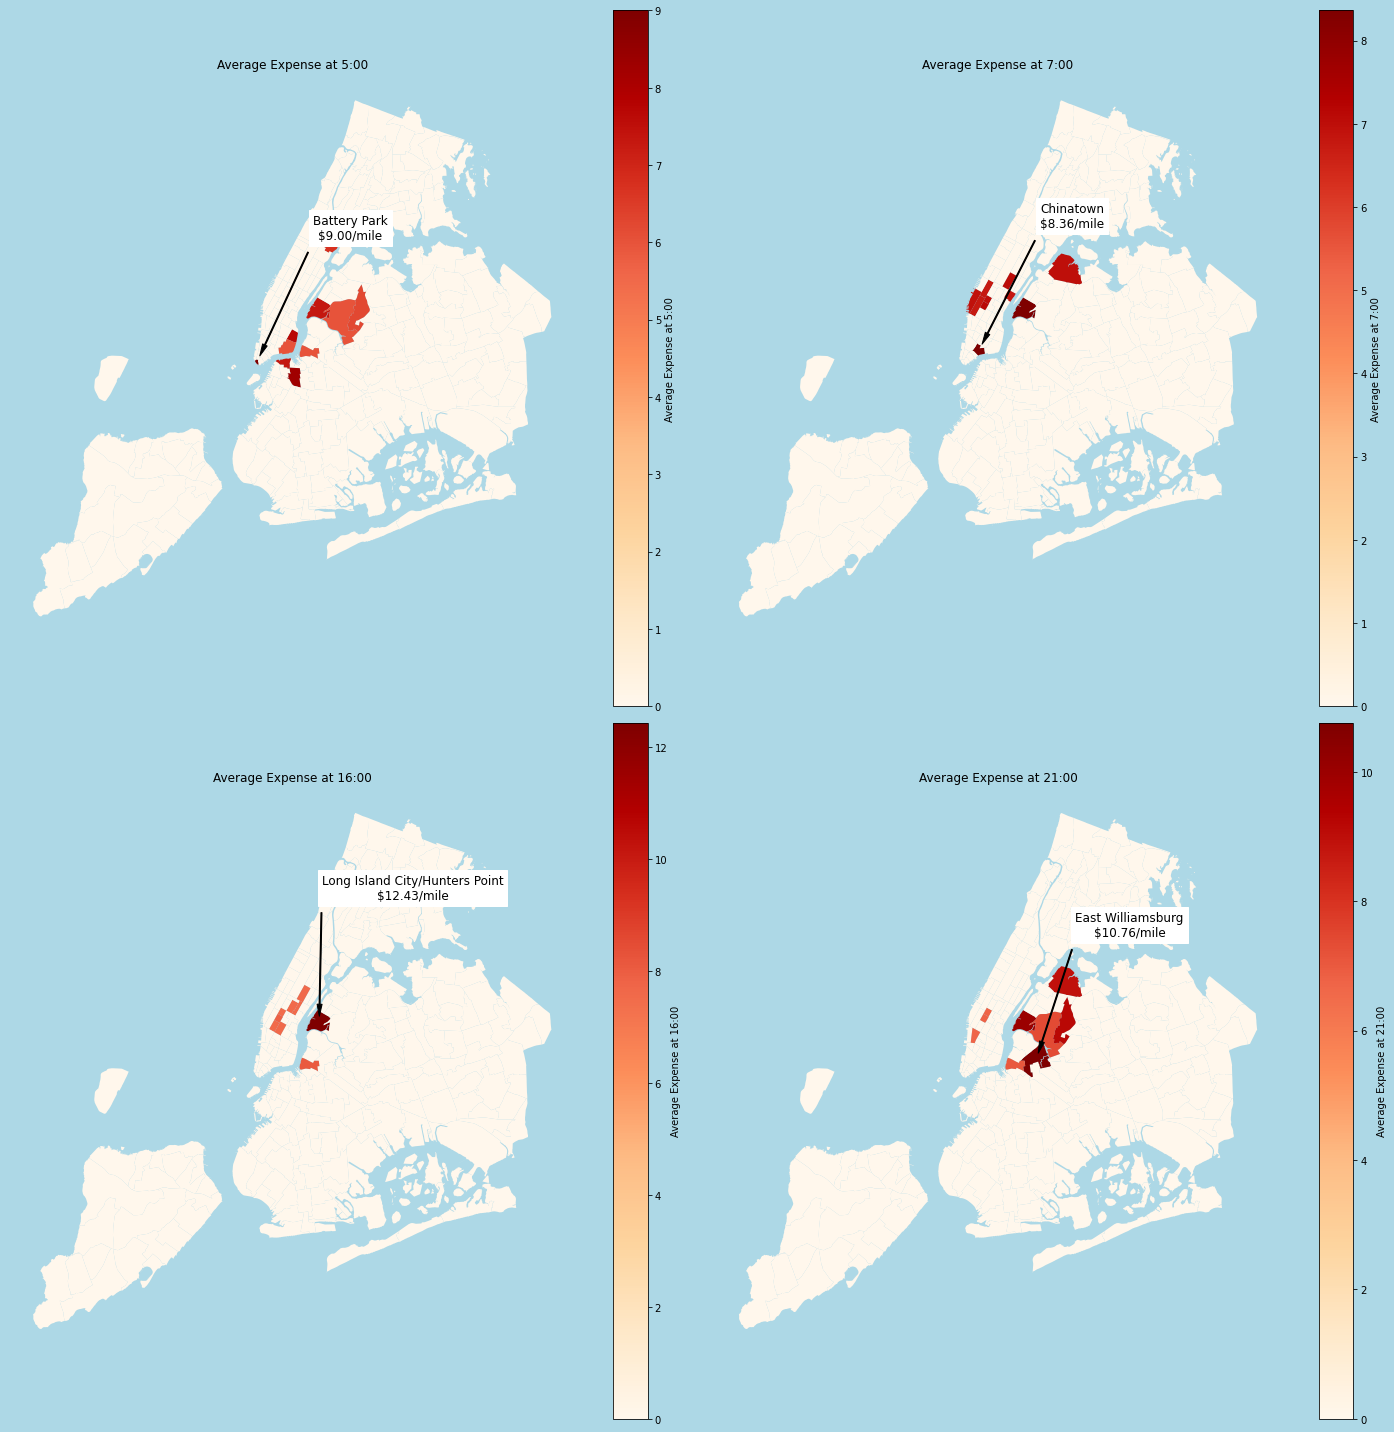

In [14]:
df = df[df['trip_distance'] > 1]

total_trips_per_location = df.groupby('PULocationID').size()
valid_locations = total_trips_per_location[total_trips_per_location >= 500].index

df = df[df['PULocationID'].isin(valid_locations)]

hours = [5, 7, 16, 21]  # 5 AM, 7 AM, 4 PM, 9 PM
top_zones_per_hour = {}

for hour in hours:
    filtered_df = df[df['hour'] == hour]
    average_expense_per_location = filtered_df.groupby('PULocationID')['expense'].mean().reset_index()
    top10_zones = average_expense_per_location.nlargest(10, 'expense')
    top_zones_per_hour[hour] = top10_zones


fig, axes = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

fig.patch.set_facecolor('#ADD8E6')
ax.set_facecolor('#ADD8E6')

for i, hour in enumerate(hours):
    top_zones = top_zones_per_hour[hour]
    merged_gdf = gdf.merge(top_zones, left_on='location_i', right_on='PULocationID', how='left')
    
    merged_gdf['expense'] = merged_gdf['expense'].fillna(0)
    
    merged_gdf.plot(column='expense', ax=axes[i], legend=True, cmap='OrRd', legend_kwds={'label': f"Average Expense at {hour}:00"})
    axes[i].set_title(f'Average Expense at {hour}:00')
    axes[i].set_axis_off()
    
    if not top_zones.empty:
        top_location = merged_gdf.loc[merged_gdf['expense'].idxmax()]
        top_location_coords = top_location['geometry'].centroid.coords[0]
        expense_value = top_location['expense']
        annotation_text = f"{top_location['zone']}\n${expense_value:.2f}/mile"
        axes[i].annotate(
            text=annotation_text,
            xy=top_location_coords,
            xytext=(top_location_coords[0] + 0.10, top_location_coords[1] + 0.10),  # Adjust offset for arrow
            ha='center', fontsize=12, color='black', backgroundcolor='white',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5)
        )

plt.tight_layout()
plt.show()

- Zones with less than 500 trips and trips with less than 1 mile distance were excluded.